# Will it be an early Spring?

On February 2<sup>nd</sup> every year Punxsutawney Phil makes a prediction about if there will be an early Spring or if Winter will continue for 6 more weeks (till about mid-March). He is however not very accurate (well, according to [The Inner Circle](https://www.groundhog.org/inner-circle) he is 100% correct but the human handler may not interpret his response correctly). The overall goal is to be able to predict if it will be an early Spring.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled final model along with this notebook.

The group with the best results on the 10% of the data that I kept for myself will earn +5 extra credit (if multiple groups are close points may be given to multiple groups).

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Frame the Problem and Look at the Big Picture
========================

1. **Define the objective in business terms.** <mark>The objective is to predict whether there will be an early Spring, allowing farmers to decide whether to purchase a new kind of corn seed that can grow two crops. Early Spring is defined as a period when the average temperature is above 40°F, the minimum temperature is above 32°F, and the average soil temperature is above 50°F before April 1st, with no snow on the ground.</mark>
2. **How will your solution be used?** <mark>The solution will be used by farmers in western PA to make informed decisions about purchasing seeds by February 25th. The prediction will help them determine if conditions will be favorable for planting the new corn seed early.</mark>
3. **What are the current solutions/workarounds (if any)?** <mark>Currently, farmers rely on Punxsutawney Phil's prediction, which is not very accurate. They may also use historical weather data and personal experience to make decisions.</mark>
4. **How should you frame this problem (supervised/unsupervised, online/offline, …)?** <mark>This problem should be framed as a supervised learning problem, where the goal is to predict a binary outcome (early Spring or not) based on historical weather and soil data. This will be a classification model, using offline learning since the most important data involves winter and spring only.</mark>
5. **How should performance be measured? Is the performance measure aligned with the business objective?** <mark>Performance should be measured using accuracy, precision, recall, and F1-score. Since the preference is to avoid false negatives (missing an early Spring), recall might be particularly important.</mark>
6. **What would be the minimum performance needed to reach the business objective?** <mark>The minimum performance needed would be a recall rate that ensures farmers can confidently make purchasing decisions with minimal risk of missing an early Spring.</mark>
7. **What are comparable problems? Can you reuse experience or tools?** <mark>We can use tools from the MNIST in-class notebook to help with this model, especially with working with binary classifiers and a classification model. </mark>
8. **Is human expertise available?** <mark>Yes, human expertise is available from the farmers who have historical data and experience with weather patterns and planting conditions.</mark>
9. **How would you solve the problem manually?** <mark>I would solve this manually by focusing on the weather conditions, soil conditions, temperature of both weather and soil, whether or not there is snow cosverage within the land in Western PA. </mark>
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** <mark>TODO</mark>

Get the Data
=======================================================================

1. **List the data you need and how much you need.** <mark>We need data to predict either an early spring, or late winter. To do that we need weather, soil, and a dataset which gives us a label feature like early spring. Also could use El Nino or La Nina data to predict this.</mark>
2. **Find and document where you can get that data:** <mark>From the client for first 3 datasets. From https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php for El Nino and La Nina data</mark>
3. **Get access authorizations:** <mark>Done</mark>
4. **Create a workspace (with enough storage space)**: This notebook.
5. **Get the data:** <mark>Got the data.</mark>
6. **Convert the data to a format you can easily manipulate (without changing the data itself):** Done, it's a CSV.
7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** Done.
8. **Check the size and type of data (time series, geographical, …):** <mark>TODO</mark> - complete in the cells below
9. **Sample a test set, put it aside, and never look at it (no data snooping!):** <mark>TODO</mark> - complete in the cells below

In [27]:
def load_and_concat_datasets(weather_file, soil_file, early_spring_file, output_file='data.csv'):
    # Load the datasets
    weather_df = pd.read_csv(weather_file)
    soil_df = pd.read_csv(soil_file)
    early_spring_df = pd.read_csv(early_spring_file)

    # Convert the 'date' in weather and 'day' in soil to datetime for proper merging
    weather_df['date'] = pd.to_datetime(weather_df['date'])
    soil_df['day'] = pd.to_datetime(soil_df['day'])

    # Merge the weather and soil data on 'date' and 'day'
    combined_df = pd.merge(weather_df, soil_df, left_on='date', right_on='day', how='inner')

    # Extract the year from 'date' in the combined dataframe
    combined_df['year'] = combined_df['date'].dt.year

    # Merge the combined_df with early_spring data only where 'year' matches
    combined_df = pd.merge(combined_df, early_spring_df, on='year', how='left')

    # Display the first few rows of the final combined DataFrame
    print(combined_df.head())

    # Save the final combined DataFrame to a CSV file
    combined_df.to_csv(output_file, index=False)

    return combined_df




def stratify_precipitation(data, precipitation_col):
    """
    Stratify precipitation into categories based on custom thresholds.

    Parameters:
    - data: DataFrame containing the precipitation data.
    - precipitation_col: The name of the column containing precipitation values.

    Returns:
    - DataFrame with a new column 'precipitation_category' added.
    """
    # Define conditions for categorization based on custom thresholds
    conditions = [
        (data[precipitation_col] == 0),               # No precipitation
        (data[precipitation_col] > 0) & (data[precipitation_col] <= 0.1),  # Light precipitation
        (data[precipitation_col] > 0.1) & (data[precipitation_col] <= 0.5),  # Moderate precipitation
        (data[precipitation_col] > 0.5)               # Heavy precipitation
    ]

    # Define category labels
    categories = ['none', 'light', 'moderate', 'heavy']

    # Create the new column 'precipitation_category'
    data['precipitation_category'] = pd.cut(
        data[precipitation_col],
        bins=[-float('inf'), 0, 0.1, 0.5, float('inf')],
        labels=categories,
        right=True
    )

    return data



def stratify_snowfall(data, snowfall_col):
    """
    Stratify snowfall into categories based on custom thresholds.

    Parameters:
    - data: DataFrame containing the snowfall data.
    - snowfall_col: The name of the column containing snowfall values.

    Returns:
    - DataFrame with a new column 'snowfall_category' added.
    """
    # Define conditions for categorization based on custom thresholds
    conditions = [
        (data[snowfall_col] == 0),            # No snowfall
        (data[snowfall_col] > 0) & (data[snowfall_col] <= 1),  # Light snowfall
        (data[snowfall_col] > 1) & (data[snowfall_col] <= 5),  # Moderate snowfall
        (data[snowfall_col] > 5)              # Heavy snowfall
    ]

    # Define category labels
    categories = ['none', 'light', 'moderate', 'heavy']

    # Create the new column 'snowfall_category'
    data['snowfall_category'] = pd.cut(
        data[snowfall_col],
        bins=[-float('inf'), 0, 1, 5, float('inf')],
        labels=categories,
        right=True
    )

    return data

def stratify_snowdepth(data, snowfall_col):
    """
    Stratify snowfall into categories based on custom thresholds.

    Parameters:
    - data: DataFrame containing the snowfall data.
    - snowfall_col: The name of the column containing snowfall values.

    Returns:
    - DataFrame with a new column 'snowfall_category' added.
    """
    # Define conditions for categorization based on custom thresholds
    conditions = [
        (data[snowfall_col] == 0),                        # No snowfall
        (data[snowfall_col] > 0) & (data[snowfall_col] <= 2),   # Light snowfall
        (data[snowfall_col] > 2) & (data[snowfall_col] <= 9),   # Moderate snowfall
        (data[snowfall_col] > 9) # Heavy snowfall
    ]

    # Define category labels
    categories = ['none', 'light', 'moderate', 'heavy']

    # Create the new column 'snowfall_category'
    data['snowdepth_category'] = pd.cut(
        data[snowfall_col],
        bins=[-float('inf'), 0, 2, 9, float('inf')],
        labels=categories,
        right=True
    )

    return data





In [28]:
# read csv file
data = load_and_concat_datasets('weather.csv', 'soil.csv', 'early_spring.csv')

        date max_temp min_temp avg_temp precipitation snowfall snowdepth  \
0 1947-01-01     30.0     24.0     27.0          0.12      0.5       1.0   
1 1947-01-02     44.0     29.0     36.5          0.49      0.0       0.0   
2 1947-01-03     54.0     41.0     47.5          0.04      0.0         M   
3 1947-01-04     42.0     24.0     33.0           0.0      0.0         M   
4 1947-01-05     33.0     25.0     29.0           0.0      0.0         M   

         day  mean_soil_temp  mean_soil_moisture  min_soil_temp  \
0 1947-01-01       -3.220000            0.477200           -4.1   
1 1947-01-02       -2.533333            0.498333           -3.2   
2 1947-01-03       -1.733333            0.515000           -2.7   
3 1947-01-04        0.729167            0.496625           -0.1   
4 1947-01-05        0.162500            0.485792           -0.7   

   min_soil_moisture  max_soil_temp  max_soil_moisture  year  early_spring  
0              0.475           -1.4              0.480  1947   

In [29]:
data

,date,max_temp,min_temp,avg_temp,precipitation,snowfall,snowdepth,day,mean_soil_temp,mean_soil_moisture,min_soil_temp,min_soil_moisture,max_soil_temp,max_soil_moisture,year,early_spring
0,1947-01-01,30.0,24.0,27.0,0.12,0.5,1.0,1947-01-01,-3.220000,0.477200,-4.1,0.475,-1.4,0.480,1947,False
1,1947-01-02,44.0,29.0,36.5,0.49,0.0,0.0,1947-01-02,-2.533333,0.498333,-3.2,0.478,-1.8,0.518,1947,False
2,1947-01-03,54.0,41.0,47.5,0.04,0.0,M,1947-01-03,-1.733333,0.515000,-2.7,0.504,-0.1,0.519,1947,False
3,1947-01-04,42.0,24.0,33.0,0.0,0.0,M,1947-01-04,0.729167,0.496625,-0.1,0.489,2.1,0.509,1947,False
4,1947-01-05,33.0,25.0,29.0,0.0,0.0,M,1947-01-05,0.162500,0.485792,-0.7,0.484,1.1,0.489,1947,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,2024-02-21,49.0,15.0,32.0,0.0,0.0,0.0,2024-02-21,0.766667,0.428458,-0.4,0.423,4.5,0.431,2024,True
3916,2024-02-22,55.0,24.0,39.5,0.0,0.0,0.0,2024-02-22,2.770833,0.436958,1.1,0.423,4.8,0.486,2024,True
3917,2024-02-23,46.0,36.0,41.0,0.53,0.0,0.0,2024-02-23,3.412500,0.491792,1.1,0.475,6.8,0.516,2024,True
3918,2024-02-24,55.0,28.0,41.5,0.0,0.0,0.0,2024-02-24,1.645833,0.472458,0.6,0.462,5.2,0.480,2024,True


In [30]:
# read ExtraDataONI.csv
oni_data = pd.read_csv('ExtraDataONI.csv')

# merge data with oni_data

data = pd.merge(data, oni_data, on='year', how='left')

In [31]:
data

,date,max_temp,min_temp,avg_temp,precipitation,snowfall,snowdepth,day,mean_soil_temp,mean_soil_moisture,min_soil_temp,min_soil_moisture,max_soil_temp,max_soil_moisture,year,early_spring,DJF
0,1947-01-01,30.0,24.0,27.0,0.12,0.5,1.0,1947-01-01,-3.220000,0.477200,-4.1,0.475,-1.4,0.480,1947,False,NaN
1,1947-01-02,44.0,29.0,36.5,0.49,0.0,0.0,1947-01-02,-2.533333,0.498333,-3.2,0.478,-1.8,0.518,1947,False,NaN
2,1947-01-03,54.0,41.0,47.5,0.04,0.0,M,1947-01-03,-1.733333,0.515000,-2.7,0.504,-0.1,0.519,1947,False,NaN
3,1947-01-04,42.0,24.0,33.0,0.0,0.0,M,1947-01-04,0.729167,0.496625,-0.1,0.489,2.1,0.509,1947,False,NaN
4,1947-01-05,33.0,25.0,29.0,0.0,0.0,M,1947-01-05,0.162500,0.485792,-0.7,0.484,1.1,0.489,1947,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,2024-02-21,49.0,15.0,32.0,0.0,0.0,0.0,2024-02-21,0.766667,0.428458,-0.4,0.423,4.5,0.431,2024,True,1.8
3916,2024-02-22,55.0,24.0,39.5,0.0,0.0,0.0,2024-02-22,2.770833,0.436958,1.1,0.423,4.8,0.486,2024,True,1.8
3917,2024-02-23,46.0,36.0,41.0,0.53,0.0,0.0,2024-02-23,3.412500,0.491792,1.1,0.475,6.8,0.516,2024,True,1.8
3918,2024-02-24,55.0,28.0,41.5,0.0,0.0,0.0,2024-02-24,1.645833,0.472458,0.6,0.462,5.2,0.480,2024,True,1.8


In [32]:
#make date column datetime

data['date'] = pd.to_datetime(data['date'])

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                3920 non-null   datetime64[ns]
 1   max_temp            3920 non-null   object        
 2   min_temp            3920 non-null   object        
 3   avg_temp            3920 non-null   object        
 4   precipitation       3920 non-null   object        
 5   snowfall            3920 non-null   object        
 6   snowdepth           3920 non-null   object        
 7   day                 3920 non-null   datetime64[ns]
 8   mean_soil_temp      3920 non-null   float64       
 9   mean_soil_moisture  3920 non-null   float64       
 10  min_soil_temp       3920 non-null   float64       
 11  min_soil_moisture   3920 non-null   float64       
 12  max_soil_temp       3920 non-null   float64       
 13  max_soil_moisture   3920 non-null   float64     

In [34]:
# List of columns to convert to float
columns_to_convert = ['max_temp', 'min_temp', 'avg_temp', 'precipitation', 
                      'snowfall', 'snowdepth', 'mean_soil_temp', 'min_soil_temp', 
                      'max_soil_temp', 'mean_soil_moisture', 'min_soil_moisture', 'max_soil_moisture']

# Convert the columns to float
for col in columns_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [35]:
# convert date into datetime
data['date'] = pd.to_datetime(data['date'])

In [36]:
# convert day into datetime
data['day'] = pd.to_datetime(data['day'])

In [37]:
# Generate a date range for January and February from 1947 to 2024
date_range = pd.date_range(start='1947-01-01', end='2024-02-28')

# Filter the date range to only include January and February
january_february_range = date_range[(date_range.month == 1) | (date_range.month == 2)]

# Find any missing dates in the 'date' column
missing_dates = january_february_range[~january_february_range.isin(data['date'])]

# Display the missing dates
missing_dates

DatetimeIndex(['1947-02-26', '1947-02-27', '1947-02-28', '1948-02-26',
               '1948-02-27', '1948-02-28', '1948-02-29', '1949-02-26',
               '1949-02-27', '1949-02-28',
               ...
               '2021-02-28', '2022-02-26', '2022-02-27', '2022-02-28',
               '2023-02-26', '2023-02-27', '2023-02-28', '2024-02-26',
               '2024-02-27', '2024-02-28'],
              dtype='datetime64[ns]', length=701, freq=None)

In [38]:
# Create a DataFrame for the missing dates
missing_dates_df = pd.DataFrame({'date': missing_dates})

# Combine the original data with the missing dates
combined_data = pd.concat([data, missing_dates_df])

# Sort the combined data by date
data = combined_data.sort_values(by='date').reset_index(drop=True)


In [39]:
# Display the first few rows and check data types of each column
print(data.dtypes)

date                  datetime64[ns]
max_temp                     float64
min_temp                     float64
avg_temp                     float64
precipitation                float64
snowfall                     float64
snowdepth                    float64
day                   datetime64[ns]
mean_soil_temp               float64
mean_soil_moisture           float64
min_soil_temp                float64
min_soil_moisture            float64
max_soil_temp                float64
max_soil_moisture            float64
year                         float64
early_spring                  object
DJF                          float64
dtype: object


In [40]:
# Calculate the percentage of missing values for each column
missing_values_percentage = data.isnull().mean() * 100
print(missing_values_percentage)


date                   0.000000
max_temp              16.360095
min_temp              16.057130
avg_temp              16.576499
precipitation         28.954772
snowfall              30.404674
snowdepth             31.205367
day                   15.169877
mean_soil_temp        15.169877
mean_soil_moisture    15.169877
min_soil_temp         15.169877
min_soil_moisture     15.169877
max_soil_temp         15.169877
max_soil_moisture     15.169877
year                  15.169877
early_spring          15.169877
DJF                   18.805453
dtype: float64


In [41]:
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Check for outliers in numerical columns
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    print(f"Outliers in {col}:")
    print(detect_outliers(data[col]).shape)


Outliers in max_temp:
(17,)
Outliers in min_temp:
(35,)
Outliers in avg_temp:
(23,)
Outliers in precipitation:
(367,)
Outliers in snowfall:
(418,)
Outliers in snowdepth:
(207,)
Outliers in mean_soil_temp:
(387,)
Outliers in mean_soil_moisture:
(7,)
Outliers in min_soil_temp:
(458,)
Outliers in min_soil_moisture:
(115,)
Outliers in max_soil_temp:
(436,)
Outliers in max_soil_moisture:
(0,)
Outliers in year:
(0,)
Outliers in DJF:
(0,)


In [42]:
# If there are categorical columns, list their unique values and counts
for col in data.select_dtypes(include=['object']).columns:
    print(f"Unique values for {col}:")
    print(data[col].value_counts())


Unique values for early_spring:
early_spring
False    1960
True     1960
Name: count, dtype: int64


In [43]:
#precipitation value counts
data['precipitation'].value_counts()

precipitation
0.00    1303
0.02     193
0.03     138
0.01     137
0.05     119
        ... 
1.20       1
1.34       1
2.05       1
1.70       1
1.65       1
Name: count, Length: 133, dtype: int64

In [44]:
# quartile info for precipitation
data['precipitation'].describe()

count    3283.000000
mean        0.131758
std         0.243531
min         0.000000
25%         0.000000
50%         0.030000
75%         0.150000
max         2.560000
Name: precipitation, dtype: float64

In [45]:
# snowfall value counts

data['snowfall'].value_counts()

snowfall
0.0     2101
1.0      223
0.5      206
2.0      105
0.2       68
        ... 
7.5        1
12.0       1
3.1        1
3.7        1
4.4        1
Name: count, Length: 67, dtype: int64

In [46]:
# quartile info for snowfall

data['snowfall'].describe()

count    3216.000000
mean        0.544714
std         1.334352
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max        21.000000
Name: snowfall, dtype: float64

In [47]:
# snowdepth value counts

data['snowdepth'].value_counts()

snowdepth
0.0     1266
1.0      448
2.0      349
3.0      224
4.0      204
5.0      134
6.0      118
8.0       74
7.0       67
9.0       47
10.0      41
12.0      31
11.0      28
18.0      17
14.0      16
15.0      15
20.0      14
16.0      12
13.0      10
22.0       9
19.0       9
17.0       9
21.0       8
24.0       6
23.0       5
25.0       4
26.0       4
28.0       3
33.0       3
30.0       2
32.0       1
31.0       1
Name: count, dtype: int64

In [48]:
# quartile info for snowdepth

data['snowdepth'].describe()

count    3179.000000
mean        2.957534
std         4.609252
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        33.000000
Name: snowdepth, dtype: float64

In [49]:
#stratify precipitation into small medium large. New column 'precipitation_category'. Separate it by Q1 and Q3

data = stratify_precipitation(data, 'precipitation')
data = stratify_snowfall(data, 'snowfall')
data = stratify_snowdepth(data, 'snowdepth')



### Splitting Data

In [50]:
from sklearn.model_selection import train_test_split

data['stratification'] = data['precipitation_category'].astype(str) + '_' + \
                         data['snowfall_category'].astype(str) + '_' + \
                         data['snowdepth_category'].astype(str)

# Keep only categories with at least 2 members so that stratifying actually works.
value_counts = data['stratification'].value_counts()
valid_categories = value_counts[value_counts >= 2].index

# Filter the data
filtered_data = data[data['stratification'].isin(valid_categories)]

# Perform the train-test split on the filtered data
train_data, test_data = train_test_split(filtered_data, test_size=0.2, 
                                         stratify=filtered_data['stratification'], 
                                         random_state=42)

# If you want to keep the original categories separate, you can stratify by one of them
# train_data, test_data = train_test_split(data, test_size=0.2, 
#                                          stratify=data['precipitation_category'], 
#                                          random_state=42)

# Check the distribution in train and test sets
train_data['stratification'].value_counts(normalize=True), test_data['stratification'].value_counts(normalize=True)

(stratification
 nan_nan_nan             0.183247
 none_none_none          0.125779
 none_none_nan           0.051233
 moderate_none_none      0.048523
 none_none_moderate      0.046896
                           ...   
 heavy_moderate_heavy    0.000542
 heavy_nan_light         0.000542
 moderate_nan_heavy      0.000542
 heavy_light_nan         0.000542
 heavy_light_moderate    0.000542
 Name: proportion, Length: 78, dtype: float64,
 stratification
 nan_nan_nan                0.183099
 none_none_none             0.125677
 none_none_nan              0.052004
 moderate_none_none         0.048754
 none_none_moderate         0.046587
                              ...   
 moderate_heavy_moderate    0.001083
 light_nan_heavy            0.001083
 moderate_nan_moderate      0.001083
 light_light_none           0.001083
 moderate_none_heavy        0.001083
 Name: proportion, Length: 71, dtype: float64)

In [51]:
# drop stratification column and precipitation_category column and snowfall_category column and snowdepth_category column

train_data = train_data.drop(columns=['stratification', 'precipitation_category', 'snowfall_category', 'snowdepth_category', 'day'])

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'max_temp'}>,
        <Axes: title={'center': 'min_temp'}>,
        <Axes: title={'center': 'avg_temp'}>],
       [<Axes: title={'center': 'precipitation'}>,
        <Axes: title={'center': 'snowfall'}>,
        <Axes: title={'center': 'snowdepth'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'mean_soil_temp'}>,
        <Axes: title={'center': 'mean_soil_moisture'}>,
        <Axes: title={'center': 'min_soil_temp'}>,
        <Axes: title={'center': 'min_soil_moisture'}>],
       [<Axes: title={'center': 'max_soil_temp'}>,
        <Axes: title={'center': 'max_soil_moisture'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'DJF'}>]], dtype=object)

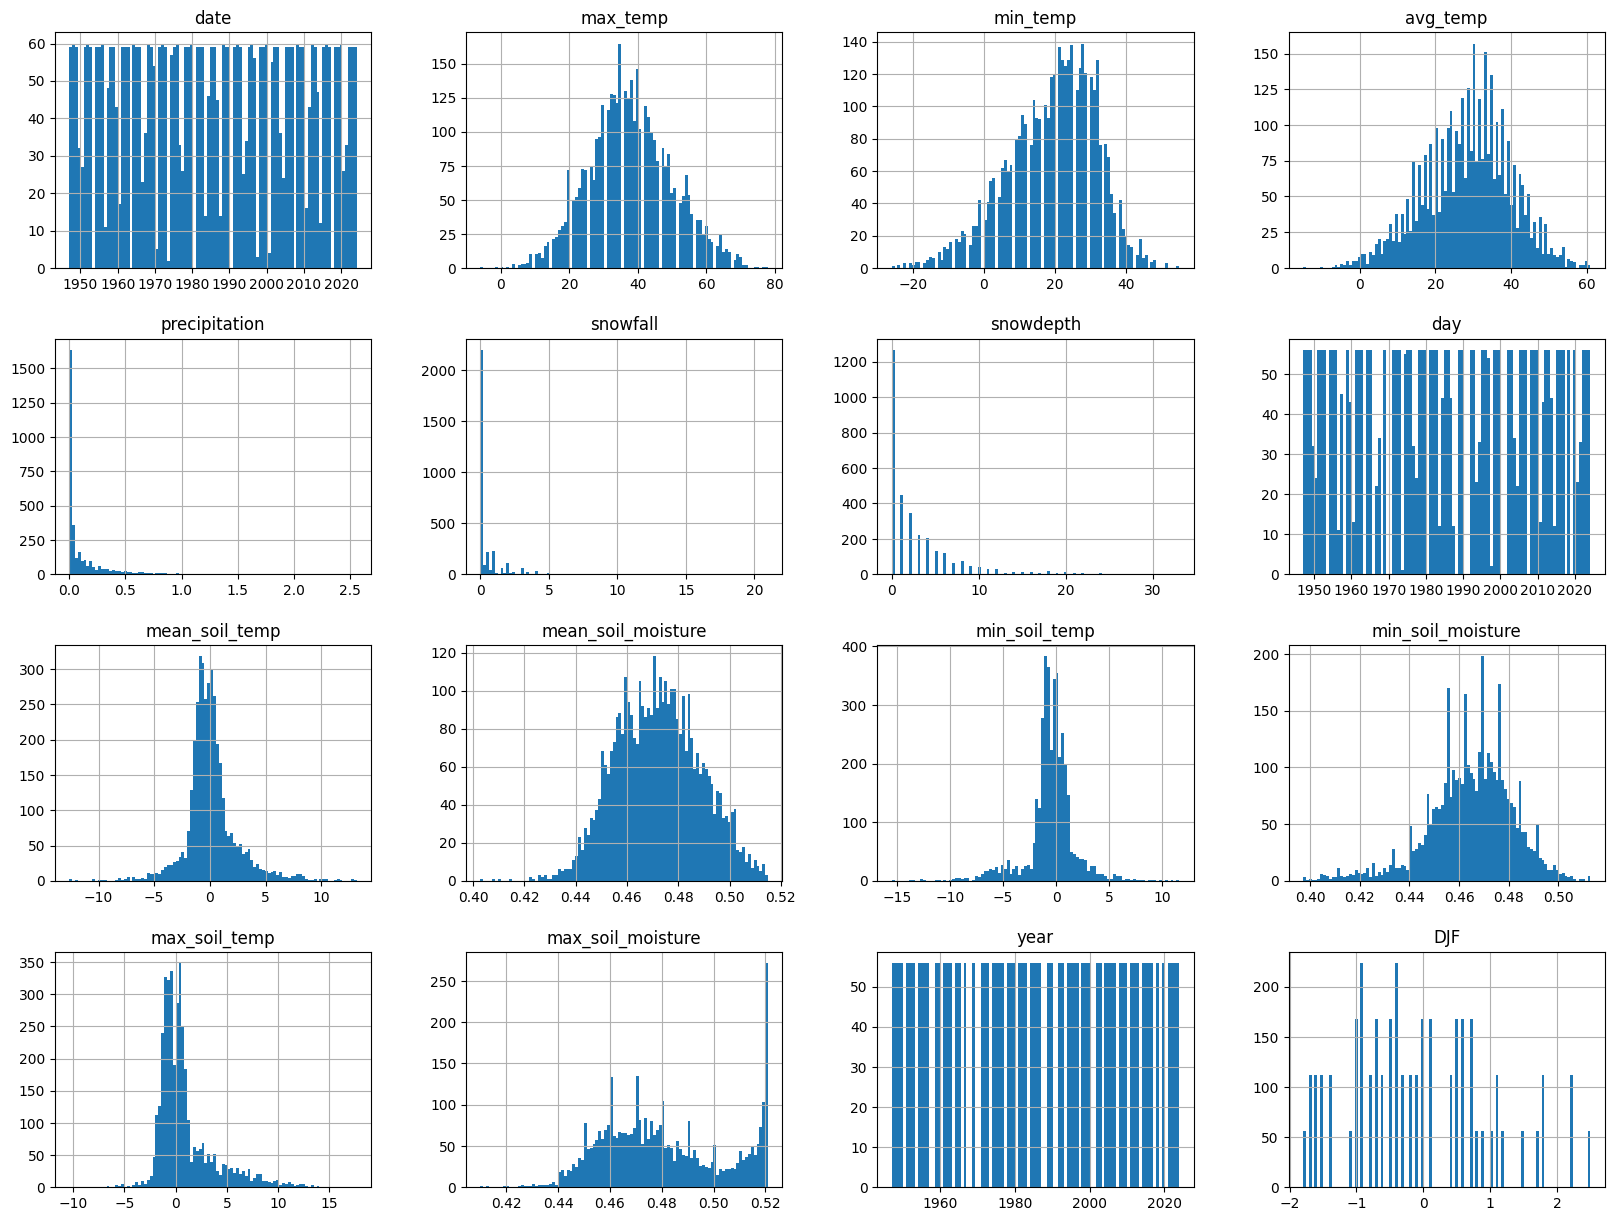

In [52]:
# histogram of all data 100 bins

data.hist(bins=100, figsize=(20, 15))

| Feature             | Type       | % Missing Values | Noisiness (Outliers, Gaps, etc.) | Usefulness (Business Goal) | Distribution                  |
|---------------------|------------|------------------|----------------------------------|-----------------------------|-------------------------------|
| **date**            | datetime | 0%               | Some missing time periods        | Useful, indicates seasonality| Fairly uniform but has gaps   |
| **max_temp**        | numerical    | 16.360095%            | Outliers detected (17)           | Highly useful (affects early spring)| Normal distribution with slight skew |
| **min_temp**        | numerical    | 16.057130%            | Outliers detected (35)           | Highly useful (affects early spring)| Normal distribution with slight skew |
| **avg_temp**        | numerical    | 16.576499%            | Outliers detected (23)           | Highly useful (affects early spring)| Normal distribution            |
| **precipitation**   | numerical    | 28.954772%           | Outliers detected (367)          | Somewhat useful (affects snow/soil) | Highly skewed (low values dominate) - Log Normal |
| **snowfall**        | numerical    | 30.404674%           | Outliers detected (418)          | Important for snow coverage | Highly skewed (many zero values) - Log Normal   |
| **snowdepth**       | numerical    | 31.205367%           | Outliers detected (207)          | Useful (indicates snow cover) | Skewed with many zero values - Log Normal     |
| **year**            | datetime      | 15.169877%               | No outliers                      | Key feature for time-based trends | Uniform, as expected for year data |
| **early_spring**    | bool       | 15.169877%               | No issues detected               | Target variable              | Binary: True/False              |
| **day**             | numerical | 15.169877%               | Some missing time periods        | Somewhat useful for daily trends | Appears consistent, but gaps exist |
| **mean_soil_temp**  | numerical    | 15.169877%               | Outliers detected (387)          | Highly relevant (affects planting)| Skewed, some negative values       |
| **mean_soil_moisture** | numerical | 15.169877%               | Outliers detected (7)          | Useful for predicting soil conditions | Skewed, concentrated around a median|
| **min_soil_temp**   | numerical    | 15.169877%               | Outliers detected (115)          | Relevant (soil temperature)  | Skewed, with negative values       |
| **min_soil_moisture**| numerical   | 15.169877%               | Outliers detected (115)            | Some relevance               | Skewed, concentrated in a narrow range|
| **max_soil_temp**   | numerical    | 15.169877%               | Outliers detected (436)          | Relevant for planting decisions | Skewed but centered             |
| **max_soil_moisture**| numerical   | 15.169877%               | No outliers                      | Useful for soil moisture trends | Right-Skewed Distribution               |
| **DJF**            | numerical    | 18.805453%            | Outliers detected (356), Some gaps          | Useful for El Nino changes | Slightly skewed, sort of Normal|

### Notes to be reminded of:
- Because we decided to insert missing dates into the dataset which we will later impute data into, if the data previously was not missing from the original dataset, it now says 15% because there was an extra 15% of days we had to insert into the data.

### Missing Values:
- Several features have significant percentages of missing values, notably **precipitation** (28.95%), **snowfall** (30.40%), and **snowdepth** (31.20%). **Mean soil temperature** and other soil-related features have about 15% missing values. Handling these missing values will be critical to ensure model accuracy.
- **Date**, the key temporal feature, has no missing values, ensuring that seasonality and time-based trends can be captured accurately.

### Outliers:
- **Snowfall**, **snow depth**, **DJF**, and **precipitation** all have many outliers, which could suggest extreme weather conditions (e.g., heavy snow or precipitation events). It’s worth considering whether to handle these outliers or let them remain, as they may represent important climate events.
- Soil-related features like **mean soil temperature** and **max soil moisture** also show significant outliers, indicating variability in soil conditions that could influence early spring predictions.
  
### Usefulness for Business Goal:
- **Max_temp**, **min_temp**, and **avg_temp** are highly useful, directly affecting early spring. These temperature-related variables are key in determining early planting windows.
- **Precipitation** and **snowfall** are somewhat useful, primarily influencing snow cover and, indirectly, soil conditions. They may not directly predict early spring but could provide supporting context.
- **Soil temperature** and **soil moisture** are highly relevant for the business goal since they directly impact planting decisions.
- **DJF** is useful for understanding winter conditions and El Niño changes. 

### Distribution:
- Most features, especially **precipitation**, **snowfall**, and **snow depth**, are **highly skewed** and follow a **log-normal distribution**, indicating that most of the values are concentrated at lower levels, with fewer extreme values.
- **Soil-related variables** have skewed distributions but seem concentrated around a median, suggesting that most values fall within a more predictable range, though there are still outliers to account for.

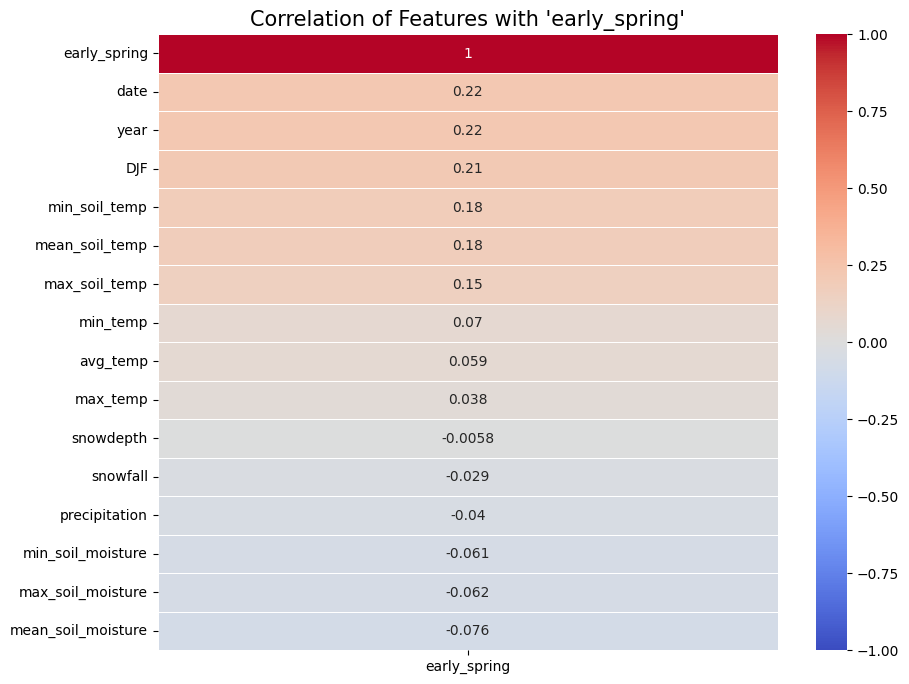

In [53]:
correlation_matrix = train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with correlation values from -1 to 1
sns.heatmap(correlation_matrix[['early_spring']].sort_values(by='early_spring', ascending=False), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Set heatmap title
plt.title("Correlation of Features with 'early_spring'", size=15)

# Show the plot
plt.show()

### Heatmap Analysis of Correlation with 'early_spring'

1. **Top Correlated Features**:
   - **Date and Year** all have moderate positive correlations (~0.22) with 'early_spring'. This indicates that these temporal features have some relationship with the occurrence of early spring, suggesting that time-based factors might influence early spring predictions.
   - **DJF (December-January-February)** also has a slightly lower correlation (~0.21) with 'early_spring', highlighting the influence of winter temperature patterns on the prediction of early spring.

2. **Soil Temperature**:
   - **Min soil temperature** and **mean soil temperature** both show a moderate positive correlation (~0.18) with early spring, indicating that warmer soil temperatures might increase the likelihood of early spring.
   - **Max soil temperature** has a weaker correlation (~0.15), but still positive, suggesting that temperature extremes might have some influence on early spring.

3. **Air Temperature**:
   - **Min temp**, **avg temp**, and **max temp** show weak correlations (between ~0.038 to 0.07) with early spring. This suggests that air temperature, while important, may not be as strong a predictor as soil-related features.

4. **Negative Correlation**:
   - **Snowfall (-0.029)**, **snow depth (-0.0058)**, and **precipitation (-0.04)** show very weak negative correlations. This suggests that these features might slightly decrease the likelihood of early spring, likely due to cold and wet conditions delaying warming trends.

5. **Moisture**:
   - Interestingly, both **max soil moisture (-0.062)** and **mean soil moisture (-0.076)** show weak negative correlations, implying that higher soil moisture levels might slightly inhibit early spring conditions.

### Key Takeaways:
- **Date**, along with **soil temperature** (especially minimum and mean soil temperature), appear to be more significant predictors for early spring. 
- **Winter temperature patterns (DJF)** also show moderate importance, suggesting seasonality influences early spring predictions.
- **Snowfall**, **snow depth**, and **precipitation** might slightly reduce the likelihood of early spring, likely due to the delayed effects of colder and wetter conditions.

Overall, focusing on temporal features and soil temperature could improve prediction accuracy for early spring, while monitoring moisture and snowfall might provide additional insights into delayed spring conditions.


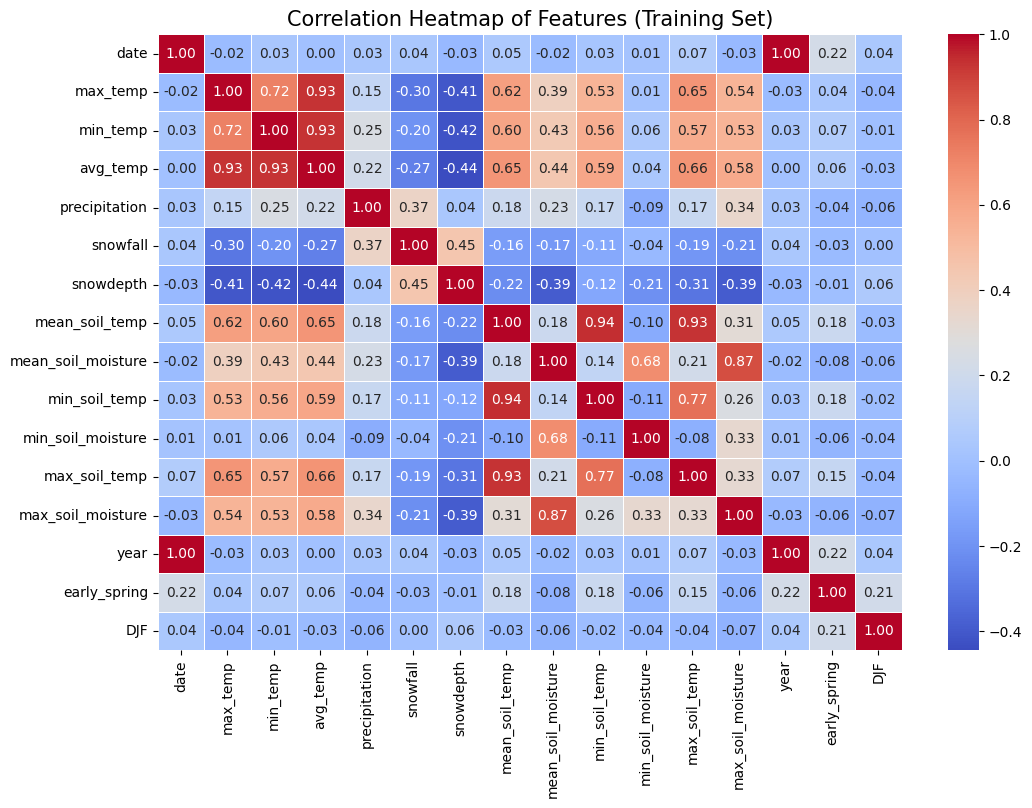

In [54]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Set the title for the heatmap
plt.title("Correlation Heatmap of Features (Training Set)", size=15)

# Show the plot
plt.show()

### Heatmap Analysis of Correlation Between Features

1. **Temperature Correlations**:
   - **Max temperature**, **min temperature**, and **average temperature** have very strong positive correlations with each other (correlation values around 0.93–1.00). This suggests that these features are highly interrelated, which makes sense because they represent different measures of temperature from the same dataset. However, this also implies possible multicollinearity when using them together in a predictive model. Might have to get rid of some or combine into one feature.
   
2. **Soil Temperature Correlations**:
   - **Mean soil temperature** is positively correlated with both **max soil temperature** (0.77) and **min soil temperature** (0.56). This indicates that mean soil temperature shares a strong relationship with the extremes of soil temperature, which could be an important factor in plant growth and predicting early spring.
   - **Max soil moisture** and **mean soil moisture** show a very strong correlation (0.87), suggesting that moisture readings follow similar patterns and that one of these variables may suffice to avoid redundancy in modeling.

3. **Precipitation and Snowfall**:
   - **Precipitation** is strongly correlated with **snowfall** (0.37) and **snow depth** (0.45), indicating that higher precipitation is associated with more snowfall and deeper snow cover. These factors likely reflect colder, wetter conditions, which could delay early spring.
   - Interestingly, **snow depth** has a weak negative correlation with **early_spring** (-0.0058), suggesting that increased snow depth may slightly delay early spring conditions.

4. **Soil Temperature and Early Spring**:
   - **Min soil temperature** (0.18), **mean soil temperature** (0.18), and **max soil temperature** (0.15) all have moderate correlations with **early_spring**. This indicates that warmer soil temperatures are moderately predictive of early spring, which aligns with biological and agricultural expectations.

5. **DJF (December-January-February Temperature)**:
   - The **DJF** feature, representing winter temperatures, shows a moderate positive correlation with **early_spring** (0.21). This implies that warmer winter temperatures could lead to earlier springs, as warmer conditions may accelerate plant growth or thawing.

6. **Multicollinearity Risk**:
   - There is high multicollinearity among temperature-related features (e.g., max_temp, min_temp, avg_temp). When selecting variables for modeling, it might be better to reduce redundancy by choosing one representative feature or to combine the featueres into one.

### Key Insights:
- Temperature features (both air and soil) play a crucial role in predicting early spring, with a focus on **soil temperature** as a critical factor.
- Temporal features such as **date**, **year**, and **day** are moderately correlated with early spring, suggesting time-related patterns.
- **Precipitation**, **snowfall**, and **snow depth** influence early spring predictions, albeit to a smaller extent, with snow depth negatively impacting early spring timing.
- There is a potential multicollinearity issue among temperature variables that may need to be addressed to improve model performance.


### Snow vs Soil
From the Heatmap correlations on all the features, I noticed a high negative correlation with snow and soil features. So will investigate further since soil has a direct correlation to the target label. 

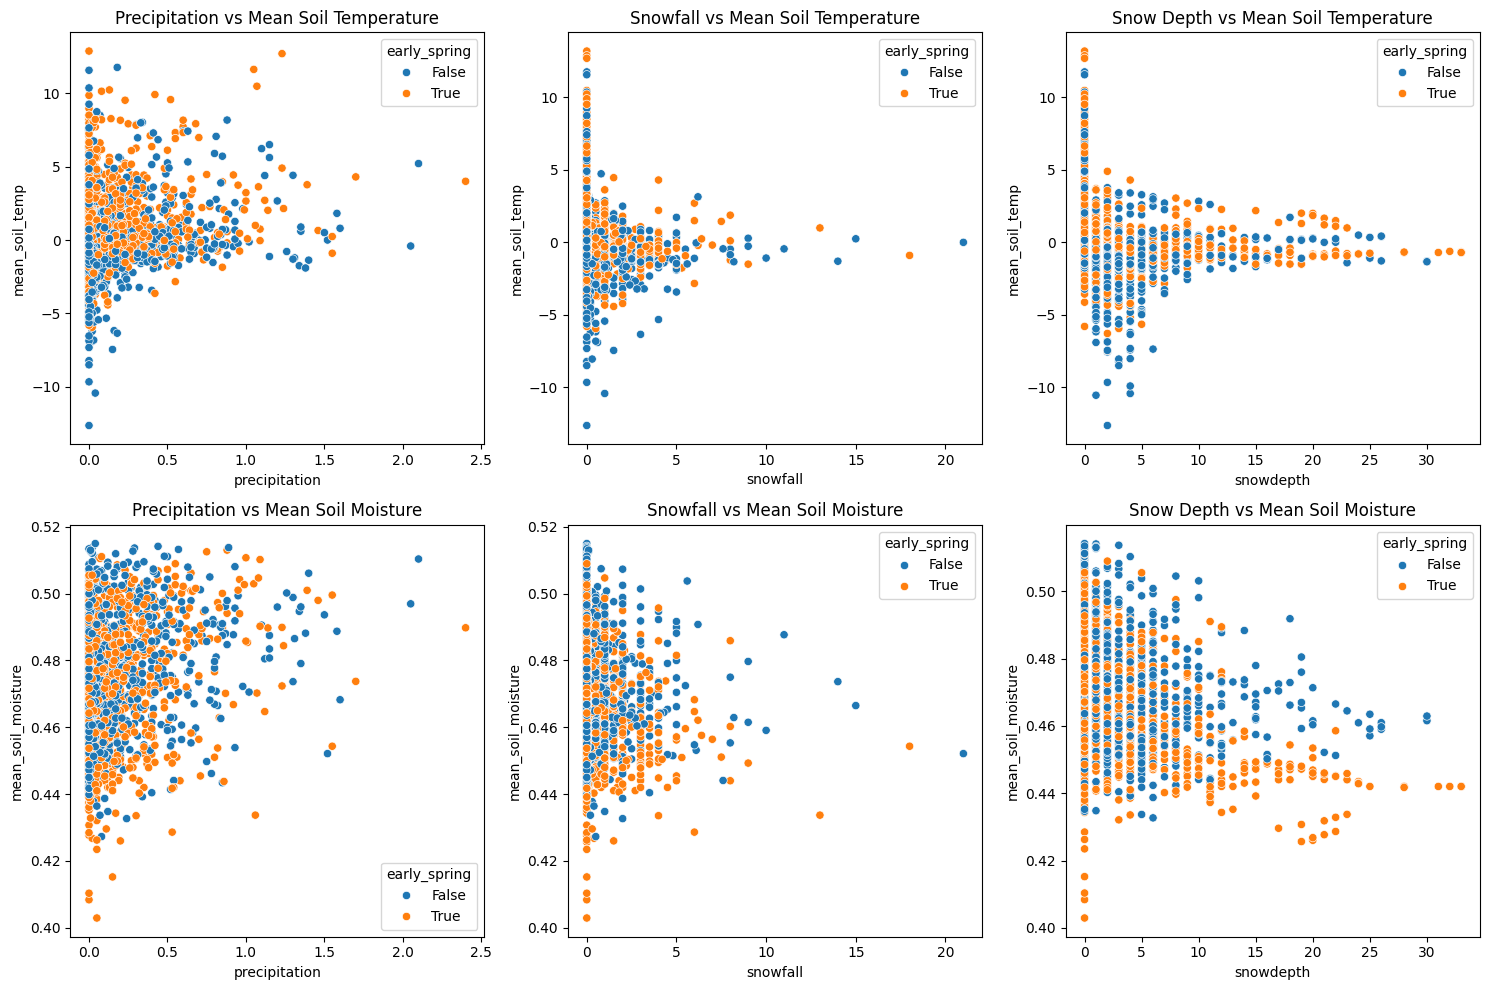

In [55]:
plt.figure(figsize=(15, 10))

# Scatter plot for Precipitation vs Mean Soil Temperature
plt.subplot(2, 3, 1)
sns.scatterplot(x='precipitation', y='mean_soil_temp', hue='early_spring', data=train_data)
plt.title('Precipitation vs Mean Soil Temperature')

# Scatter plot for Snowfall vs Mean Soil Temperature
plt.subplot(2, 3, 2)
sns.scatterplot(x='snowfall', y='mean_soil_temp', hue='early_spring', data=train_data)
plt.title('Snowfall vs Mean Soil Temperature')

# Scatter plot for Snow Depth vs Mean Soil Temperature
plt.subplot(2, 3, 3)
sns.scatterplot(x='snowdepth', y='mean_soil_temp', hue='early_spring', data=train_data)
plt.title('Snow Depth vs Mean Soil Temperature')

# Scatter plot for Precipitation vs Mean Soil Moisture
plt.subplot(2, 3, 4)
sns.scatterplot(x='precipitation', y='mean_soil_moisture', hue='early_spring', data=train_data)
plt.title('Precipitation vs Mean Soil Moisture')

# Scatter plot for Snowfall vs Mean Soil Moisture
plt.subplot(2, 3, 5)
sns.scatterplot(x='snowfall', y='mean_soil_moisture', hue='early_spring', data=train_data)
plt.title('Snowfall vs Mean Soil Moisture')

# Scatter plot for Snow Depth vs Mean Soil Moisture
plt.subplot(2, 3, 6)
sns.scatterplot(x='snowdepth', y='mean_soil_moisture', hue='early_spring', data=train_data)
plt.title('Snow Depth vs Mean Soil Moisture')

plt.tight_layout()
plt.show()

### Analysis of Snow and Precipitation Features with Soil:

#### 1. **Precipitation vs. Mean Soil Temperature**
- **Observation**: There is a weak positive correlation between precipitation and mean soil temperature. Higher precipitation slightly increases soil temperature.
- **Key Point**: Both early spring (orange) and non-early spring (blue) data points are spread similarly across precipitation values, with early spring occurring more frequently at lower precipitation levels.

#### 2. **Snowfall vs. Mean Soil Temperature**
- **Observation**: Snowfall seems to correlate slightly with lower soil temperatures. Early spring events occur more often when soil temperatures are higher, but no strong separation is visible between the two classes.
- **Key Point**: Snowfall influences soil temperature, but not in a way that clearly distinguishes early spring from other conditions.

#### 3. **Snow Depth vs. Mean Soil Temperature**
- **Observation**: Snow depth has a more noticeable negative effect on soil temperature, where higher snow depths correspond to lower soil temperatures. Early spring is more likely to happen when snow depth is lower and soil temperature is higher.
- **Key Point**: Snow depth is a significant factor to investigate further, as it has a clear relationship with both soil temperature and early spring. The data shows that lower snow depths are associated with higher soil temperatures, which are conducive to early spring conditions.

#### 4. **Precipitation vs. Mean Soil Moisture**
- **Observation**: Precipitation positively affects soil moisture, but there is no clear distinction between early spring and non-early spring based on precipitation levels.
- **Key Point**: Precipitation increases soil moisture, but on its own, it may not strongly predict early spring conditions.

#### 5. **Snowfall vs. Mean Soil Moisture**
- **Observation**: Snowfall shows a mild positive impact on soil moisture, but again, there is no clear separation between early spring and non-early spring events.
- **Key Point**: Snowfall, while affecting soil moisture, does not strongly influence early spring predictions.

#### 6. **Snow Depth vs. Mean Soil Moisture**
- **Observation**: Snow depth has a more consistent and stronger positive correlation with soil moisture. Early spring tends to occur at lower snow depths where soil moisture is still at a reasonable level.
- **Key Point**: Snow depth not only affects soil temperature but also significantly impacts soil moisture. This makes it an essential variable for predicting early spring, as lower snow depth likely indicates better soil conditions for planting.

### **Overall:**
- **Snow depth** is a crucial feature to focus on due to its strong relationship with both soil temperature and moisture, which are critical for early spring predictions.
- Precipitation and snowfall affect soil conditions but are not as strong predictors of early spring on their own.
- Further analysis should prioritize snow depth when building models to predict early spring, especially in combination with soil temperature and moisture.


<Figure size 2000x1000 with 0 Axes>

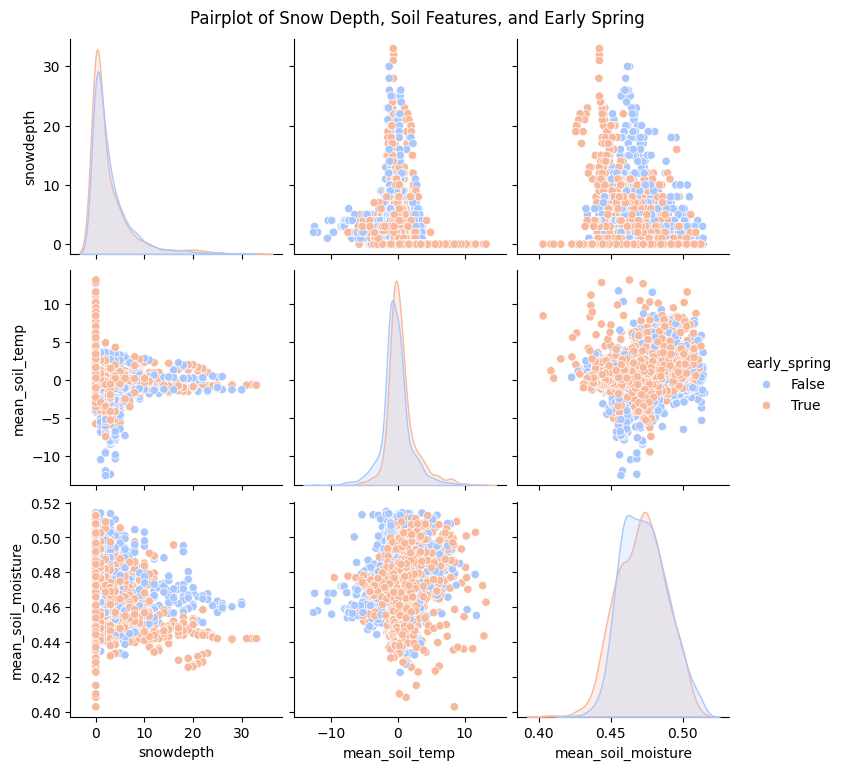

In [56]:

plt.figure(figsize=(20, 10))

# Investigate the joint relationship between snow depth and soil temperature & moisture using pairplot
sns.pairplot(data[['snowdepth', 'mean_soil_temp', 'mean_soil_moisture', 'early_spring']], hue='early_spring', palette='coolwarm')
plt.suptitle('Pairplot of Snow Depth, Soil Features, and Early Spring', y=1.02)

# Show all the plots
plt.show()


### Snow Depth, Soil Features, and Early Spring

- **Snow Depth vs. Mean Soil Temperature**:
    - The plot shows that as snow depth increases, mean soil temperature tends to decrease, with more spread observed at lower snow depths. However, there is a notable cluster of data points near a snow depth of 0 with a higher mean soil temperature.
    - This relationship suggests that snow cover could insulate the soil, keeping temperatures low during periods of higher snow depth. However, there are still many cases where snow depth is low, and the soil temperature varies significantly.
    - Early spring cases (orange) are slightly more clustered at lower snow depths, suggesting that early spring is more likely to occur when there is less snow.

- **Snow Depth vs. Mean Soil Moisture**:
    - There appears to be a weak correlation between snow depth and soil moisture. Most points are clustered in a relatively narrow range of soil moisture (between 0.44 and 0.50), with snow depth showing more variance.
    - While snow contributes to soil moisture through melting, the impact of snow depth on soil moisture is not as strong, likely due to other factors like precipitation and the rate of snowmelt.
    - Both early and non-early spring cases are spread similarly across the snow depth and soil moisture axes, with no strong separation.

- **Overall Insights**:
    - The relationship between **snow depth** and **soil temperature** is of particular interest. Lower snow depth is associated with higher soil temperatures, which could play a role in determining early spring conditions.
    - **Snow depth** does affect **soil moisture**, but the impact on early spring is not clearly distinguishable based on these features alone.
    - Early spring data does show some distinct patterns, particularly with soil temperature, indicating that it might be worthwhile to focus more on **soil temperature** in relation to snow depth and moisture for further investigation.

This plot confirms that **snow depth** has an indirect effect on the target variable (early spring) via its impact on **soil temperature** and **soil moisture**. Further exploration and perhaps feature engineering around snow depth and soil features could enhance prediction accuracy for early spring.

### DJF vs. Early Spring:

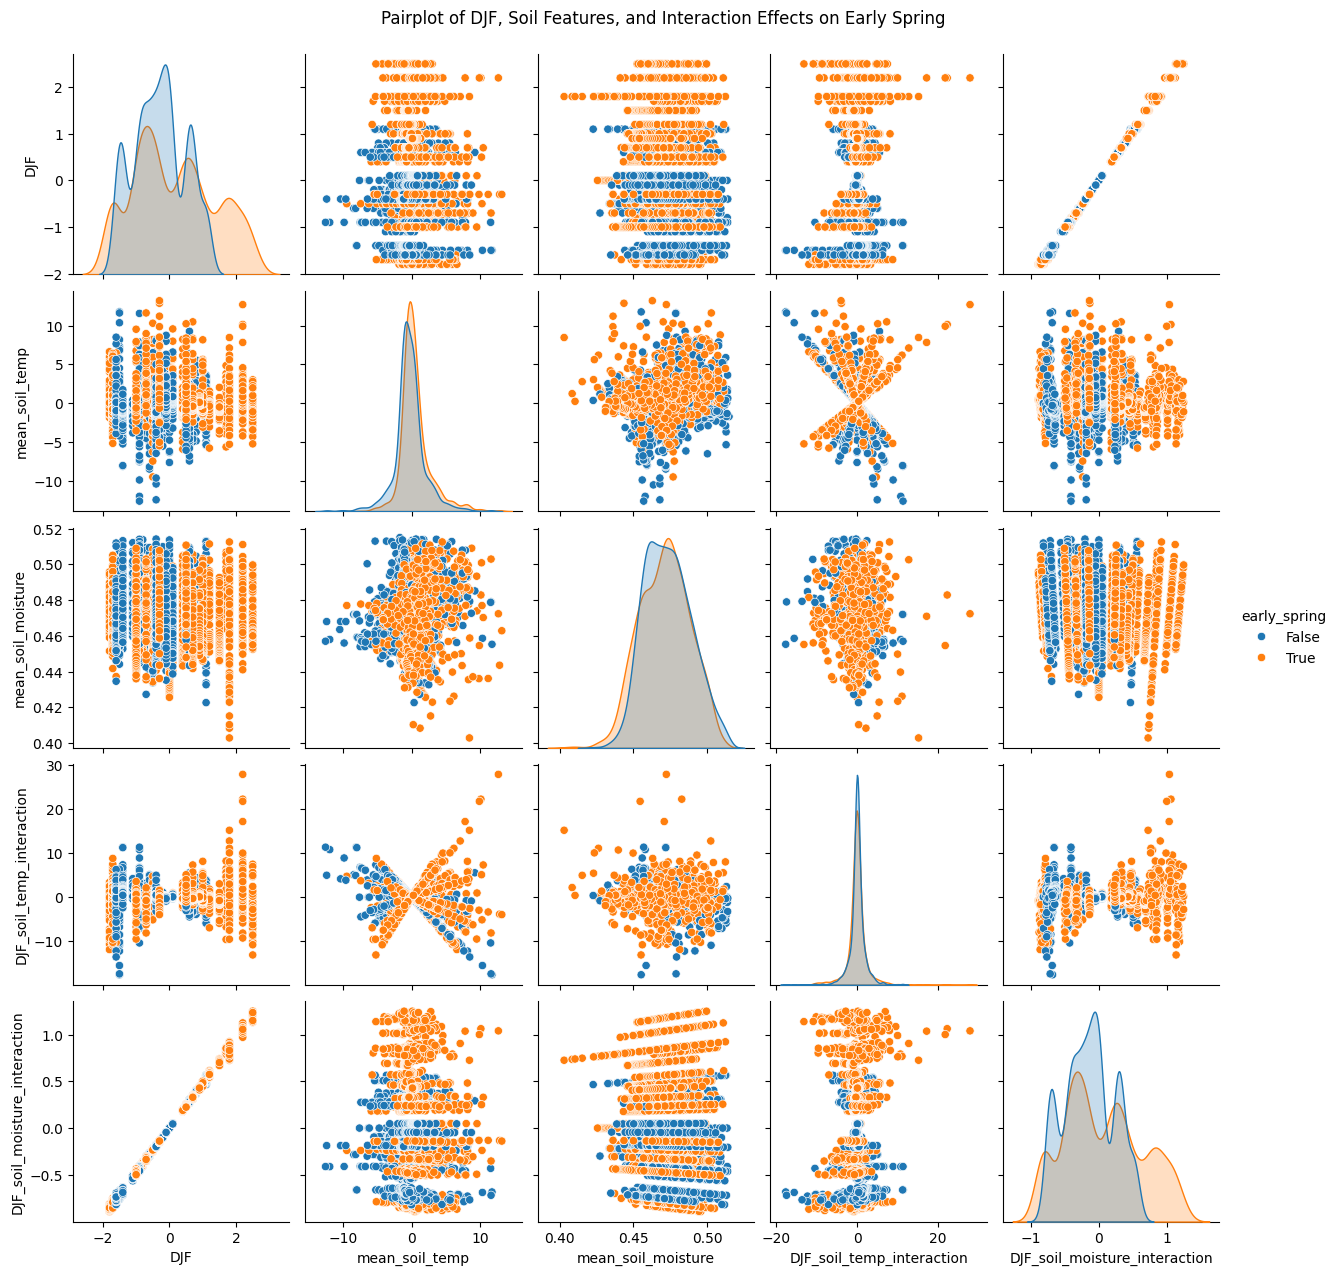

In [57]:
# Interaction Effects with Soil Features
data['DJF_soil_temp_interaction'] = data['DJF'] * data['mean_soil_temp']
data['DJF_soil_moisture_interaction'] = data['DJF'] * data['mean_soil_moisture']

sns.pairplot(data, vars=['DJF', 'mean_soil_temp', 'mean_soil_moisture', 'DJF_soil_temp_interaction', 'DJF_soil_moisture_interaction'], hue='early_spring', diag_kind='kde')
plt.suptitle('Pairplot of DJF, Soil Features, and Interaction Effects on Early Spring', y=1.02)
plt.show()

1. **DJF and Early Spring**:
   - The distribution of DJF values shows that **warmer winters (higher DJF values)** are more associated with **early spring occurrences** (orange).
   - **Colder winters** (lower DJF values) are more often related to **no early spring** (blue).

2. **Interaction Effects**:
   - The interaction plots show that **DJF combined with soil temperature** has a clearer separation between early spring and no early spring occurrences.
   - **DJF and soil moisture interaction** also provides some distinction, but the separation is less defined than temperature interactions.
   
3. **General Trend**:
   - **Warmer winters** (higher DJF) coupled with **higher soil temperatures** increase the likelihood of early spring.
   - Soil moisture shows some impact, but it is less significant in distinguishing early spring compared to soil temperature.


### Threshold Analysis for DJ:

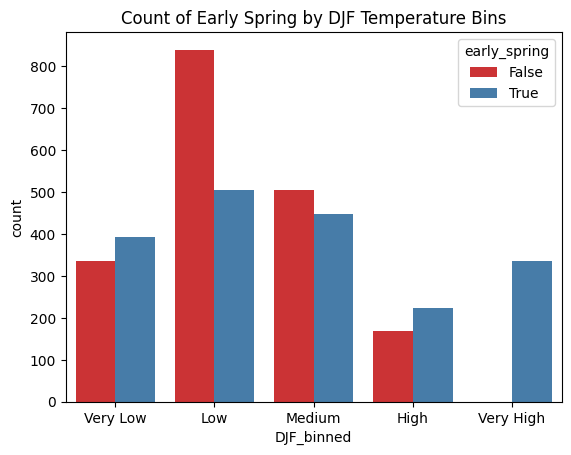

In [58]:

data['DJF_binned'] = pd.cut(data['DJF'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

sns.countplot(x='DJF_binned', hue='early_spring', data=data, palette="Set1")
plt.title('Count of Early Spring by DJF Temperature Bins')
plt.show()

- **Low DJF Temperatures (Low, Very Low)**: There are significantly more instances of **early spring being false** (red) when DJF temperatures are in the low or very low range. This suggests that colder winter conditions (DJF) are less likely to result in an early spring.
  
- **Medium DJF Temperatures**: This bin shows a more balanced distribution between true and false early spring occurrences, though **false still dominates slightly**. It indicates that medium winter temperatures can go either way but lean toward no early spring.

- **High and Very High DJF Temperatures**: For **higher DJF temperatures**, the trend reverses with **more early spring occurrences** (blue). Warmer winter periods are more conducive to predicting an early spring.
  
### Overall:
- The DJF temperature bins suggest a clear correlation between **warmer DJF temperatures** and the likelihood of **early spring**, while **colder DJF temperatures** are linked to a higher probability of no early spring.


### **Data Exploration Summary**

1. **Correlation Analysis**:
   - **Mean Soil Temperature**, **Min Soil Temperature**, and **Max Soil Temperature** show the strongest positive correlations with the target variable, `early_spring`.
   - **Precipitation**, **Snowfall**, and **Snow Depth** have weak correlations with `early_spring`. However, they hold a indirect correlation to the target label.
   - **DJF** (Winter temperature) also shows a moderate correlation with `early_spring`, making it an important feature.

2. **Interaction Effects**:
   - Interaction between **DJF** and soil features such as **mean soil temperature** and **mean soil moisture** shows interesting patterns, particularly in distinguishing between early spring and non-early spring outcomes.
   - **Snow Depth** also appears to have a visual interaction with **soil temperature**, though the scatter plot analysis suggests that snow depth alone may not be a strong predictor unless combined with soil temperature.

3. **Key Takeaways from Visualizations**:
   - The scatter plots and histograms indicate that **soil temperature** is a critical variable that varies significantly between early spring and non-early spring cases.
   - **Snow Features** appear to have an indirect effect on **soil temperature**, which influence early spring predictions.

4. **DJF Feature**:
   - DJF (December-February temperature averages) plays a significant role in early spring predictions. The count plot of early spring by DJF bins shows that medium to high DJF values correlate more with early spring occurrences, whereas very low DJF values correlate with the absence of early spring.